In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Read the data
For both the heatmaps and the featuremaps, extract the data about
- The approaches used.
- The clusters obtained with each approach.
- The time taken to compute the clusters.

For the featuremaps, the data might be filtered for some specific configuration.

In [10]:
import pandas as pd

# Read the featuremaps clusters data
featuremaps_df = pd.read_pickle('../logs/feature_combinations_clusters').reset_index()
# Compute the total time
featuremaps_df['time'] = featuremaps_df['map_time'] + featuremaps_df['features_extraction']
featuremaps_df = featuremaps_df.drop(columns=['map_time', 'features_extraction'])

# Get the original clusters
featuremaps_original_clusters_df = pd.DataFrame(data = featuremaps_df[['approach', 'clusters_list', 'time']].values, columns=['approach', 'clusters', 'time'])
featuremaps_original_clusters_df['approach'] = featuremaps_original_clusters_df['approach'].apply(lambda approach: approach + '_original')
# Get the merged clusters
featuremaps_merged_clusters_df = pd.DataFrame(data = featuremaps_df[['approach', 'merged_clusters_list', 'time']].values, columns=['approach', 'clusters', 'time'])
featuremaps_merged_clusters_df['approach'] = featuremaps_merged_clusters_df['approach'].apply(lambda approach: approach + '_merged')
# Add the clusters
featuremaps_all_clusters_df = pd.concat([featuremaps_original_clusters_df, featuremaps_merged_clusters_df]).reset_index(drop=True)

# Filter for the desired approach
featuremaps_all_clusters_df = featuremaps_all_clusters_df[
    (featuremaps_all_clusters_df['approach'].str.contains('(10x10)')) &
    (featuremaps_all_clusters_df['approach'].str.contains('original'))
]

featuremaps_all_clusters_df

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_1105/3805808078.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (featuremaps_all_clusters_df['approach'].str.contains('(10x10)')) &


,approach,clusters,time
0,moves+orientation(10x10)_original,"[[28, 119, 263, 277, 339, 453], [20, 38, 72, 8...",26.846361
1,moves+bitmaps(10x10)_original,"[[670], [48, 163, 252, 254, 274, 279, 401, 426...",26.817801
2,orientation+bitmaps(10x10)_original,"[[28, 339, 453], [119, 263, 277], [248], [252,...",26.84524


In [12]:
import pandas as pd
import ast

# Read the heatmaps data
heatmaps_df = pd.read_csv('../logs/heatmaps_data.csv')
heatmaps_df['clusters'] = heatmaps_df['clusters'].apply(ast.literal_eval)

# Extract the clusters df
heatmaps_clusters_df = heatmaps_df[['clustering_mode', 'explainer', 'clustering_technique', 'clusters', 'time_clustering', 'time_contributions']]
heatmaps_clusters_df['clustering_mode'] = heatmaps_clusters_df.apply(lambda row: f'{row["clustering_technique"]}({row["clustering_mode"]})', axis=1)
heatmaps_clusters_df = heatmaps_clusters_df.drop(columns=['clustering_technique'])
heatmaps_clusters_df = heatmaps_clusters_df.rename(columns={'explainer': 'approach'})
heatmaps_clusters_df['time'] = heatmaps_clusters_df['time_clustering'] + heatmaps_clusters_df['time_contributions']
heatmaps_clusters_df = heatmaps_clusters_df.drop(columns=['time_clustering', 'time_contributions'])
heatmaps_clusters_df = heatmaps_clusters_df.groupby(['clustering_mode', 'approach']).first().reset_index()

heatmaps_clusters_df.head()

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_1105/3953204512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmaps_clusters_df['clustering_mode'] = heatmaps_clusters_df.apply(lambda row: f'{row["clustering_technique"]}({row["clustering_mode"]})', axis=1)


,clustering_mode,approach,clusters,time
0,AffinityPropagation(LocalLatentMode),GradCAM,"[[0, 385, 258, 3, 389, 146, 25, 282, 409, 161,...",3.87692
1,AffinityPropagation(LocalLatentMode),IntegratedGradients,"[[0, 640, 2, 259, 4, 642, 643, 392, 140, 143, ...",51.00501


In [14]:
from utils.dataset import get_train_test_data, get_data_masks
import pandas as pd
import numpy as np

# Merge all the clusters together
complete_df = pd.concat([featuremaps_all_clusters_df, heatmaps_clusters_df]).reset_index(drop=True)

# Extract the data about the number of clusters
complete_df['num_clusters'] = complete_df['clusters'].apply(len)
# Extract data about the clusters sizes
complete_df['clusters_sizes'] = complete_df['clusters'].apply(lambda clusters: [len(cluster) for cluster in clusters])

# Get the indexes of the misclassified elements
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True)
predictions = np.loadtxt('../in/predictions.csv')
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5)
mask_miss_label = mask_miss[mask_label]
misclassified_idxs = np.argwhere(mask_miss_label == True)
# Find the fraction of misclassified data in each cluster
complete_df['frac_misses'] = complete_df['clusters'].apply(
    lambda clusters: [
        len([entry for entry in cluster if entry in misclassified_idxs]) / len(cluster)
        for cluster in clusters
    ]
)
# Find the fraction of clusters containing both correct and incorrect classifications
complete_df['frac_mixed'] = complete_df['frac_misses'].apply(lambda misses: len([entry for entry in misses if 0 < entry < 1]) / len(misses))

complete_df

,approach,clusters,time,clustering_mode,num_clusters,clusters_sizes,frac_misses,frac_mixed
0,moves+orientation(10x10)_original,"[[28, 119, 263, 277, 339, 453], [20, 38, 72, 8...",26.846361,NaN,44,"[6, 41, 76, 115, 118, 220, 176, 42, 7, 1, 1, 2...","[0.16666666666666666, 0.4146341463414634, 0.31...",0.431818
1,moves+bitmaps(10x10)_original,"[[670], [48, 163, 252, 254, 274, 279, 401, 426...",26.817801,NaN,47,"[1, 15, 90, 222, 208, 148, 90, 21, 6, 1, 1, 1,...","[1.0, 0.4666666666666667, 0.3111111111111111, ...",0.319149
2,orientation+bitmaps(10x10)_original,"[[28, 339, 453], [119, 263, 277], [248], [252,...",26.84524,NaN,55,"[3, 3, 1, 2, 3, 16, 16, 3, 2, 5, 26, 15, 24, 9...","[0.3333333333333333, 0.0, 0.0, 1.0, 0.66666666...",0.709091
3,GradCAM,"[[0, 385, 258, 3, 389, 146, 25, 282, 409, 161,...",3.87692,AffinityPropagation(LocalLatentMode),25,"[32, 42, 32, 42, 26, 26, 39, 41, 37, 46, 42, 5...","[0.03125, 0.047619047619047616, 0.09375, 0.071...",0.920000
4,IntegratedGradients,"[[0, 640, 2, 259, 4, 642, 643, 392, 140, 143, ...",51.00501,AffinityPropagation(LocalLatentMode),25,"[37, 27, 25, 47, 42, 34, 43, 33, 24, 45, 33, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.040000


# Explore the most common clusters across the different approaches
Consider the clusters in all the approaches and find the ones occurring more often.

In [6]:
from utils.general import get_common_clusters

# Flatten the list of clusters, remove singletons and black-hole
all_clusters = complete_df['clusters'].to_list()
# Find the most common clusters containing misclassified elements
most_common_clusters = [cluster for cluster, _ in get_common_clusters(all_clusters, mask=mask_miss_label)[:4]]

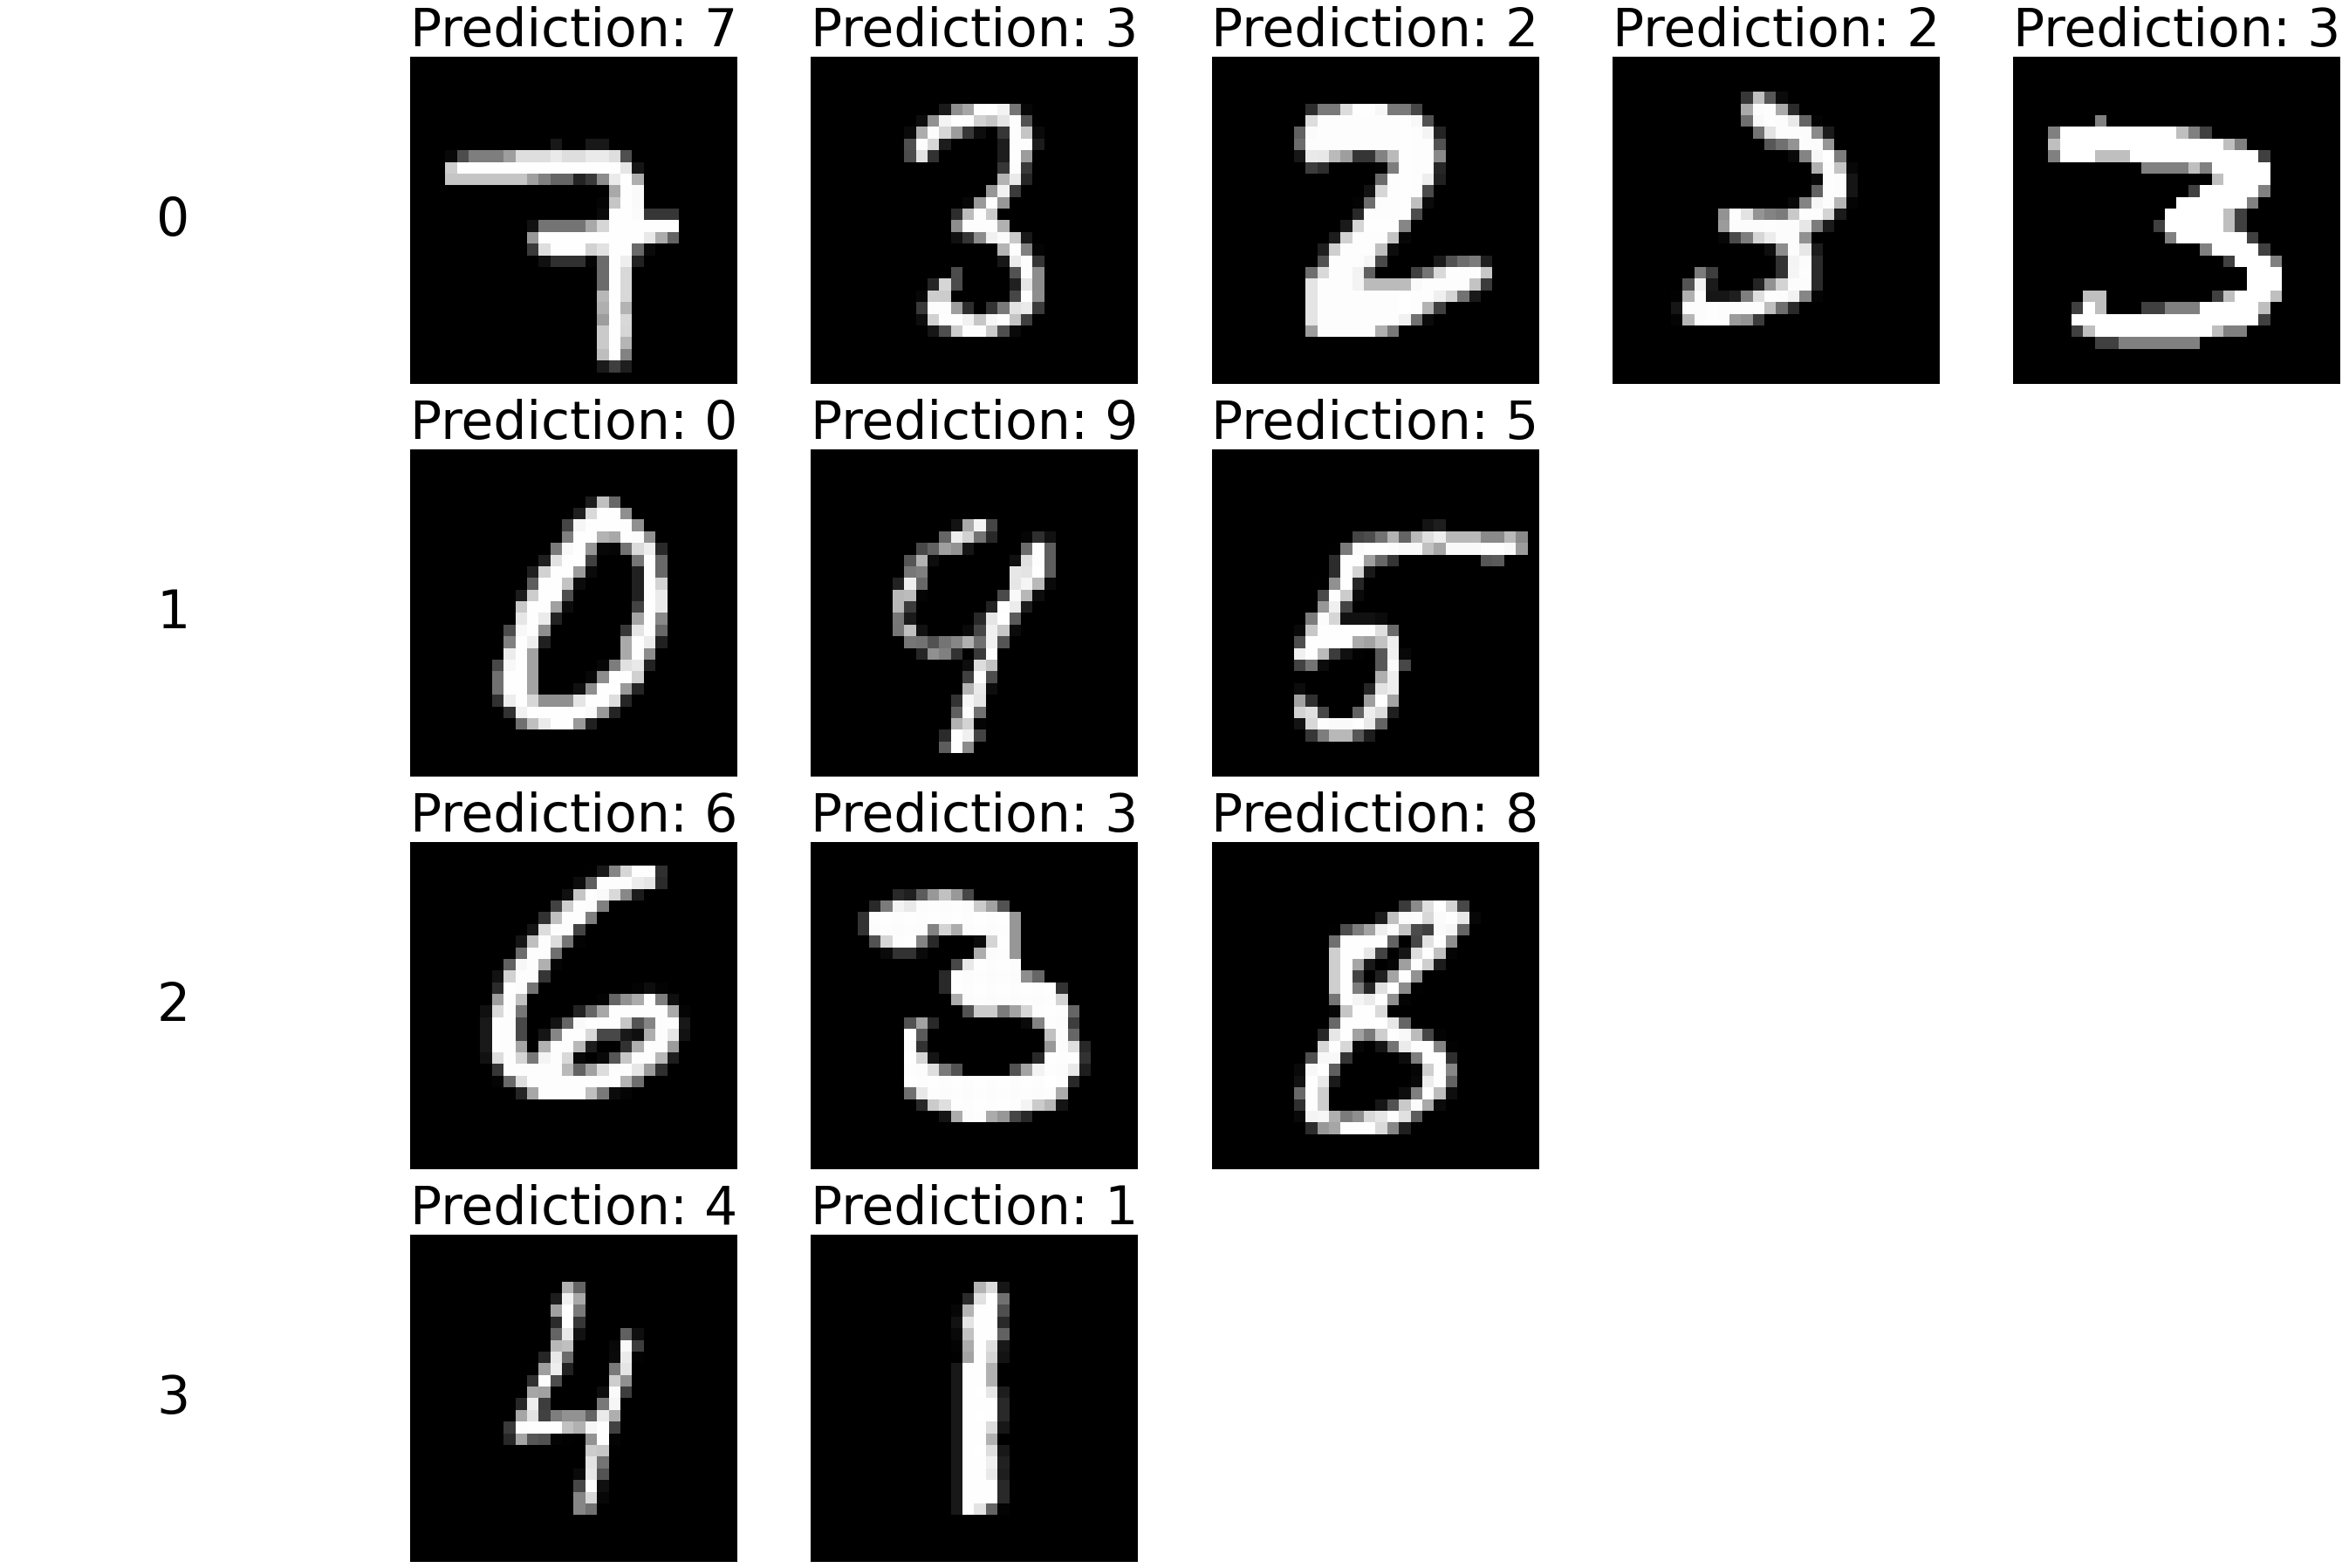

In [7]:
import numpy as np
from utils.cluster.visualize import visualize_clusters_images
from utils.cluster.postprocessing import get_non_unique_membership_list

# Find the images for the most common clusters
most_common_clusters_list = get_non_unique_membership_list(most_common_clusters)
most_common_clusters_idxs = list(set(sorted(
    idx
    for cluster in most_common_clusters for idx in cluster
)))
most_common_clusters_imgs = np.array([test_data[idx] for idx in most_common_clusters_idxs])
most_common_clusters_predictions = predictions[most_common_clusters_idxs]

fig, _ = visualize_clusters_images(
    clusters=most_common_clusters_list,
    images=most_common_clusters_imgs,
    predictions=most_common_clusters_predictions,
    cmap='gray_r',
    max_samples=5
)

# Compute the distance matrix for all the approaches (low-level + high-level)

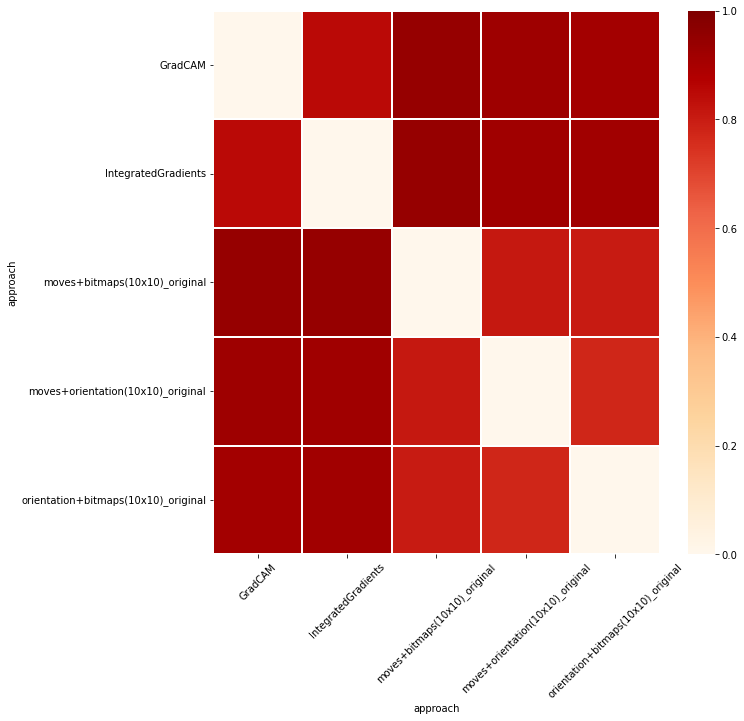

In [9]:
from clusim.clusimelement import element_sim
from utils.cluster.preprocessing import distance_matrix
from clusim.clustering import Clustering

clusters_configs = complete_df['clusters'].values
distance_matrix, fig, ax = distance_matrix(
        [Clustering().from_cluster_list(clusters) for clusters in clusters_configs],
        lambda l, r: 1 - element_sim(l, r),
        show_map=True,
        names=complete_df['approach']
    )